In [1]:
import zipfile

with zipfile.ZipFile("walmart-10k-sales-datasets.zip", 'r') as zip_ref:
    zip_ref.extractall("unzipped_data")

print("Unzipped successfully!")

Unzipped successfully!


In [2]:
import pandas as pd

# Load the raw dataset
df = pd.read_csv('unzipped_data/Walmart.csv', encoding_errors='ignore')


# --- DATA CLEANING ---

#removing dollar sign and changing data type from str to float
df['unit_price'] = df['unit_price'].str.replace('$','', regex = False).astype(float)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Fill missing numeric values with median
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing categorical values with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Adding new column Revenue
# Example: Revenue = unit price * quantity

if {'unit_price',  'profit_margin', 'quantity'}.issubset(df.columns):
    df['Revenue'] = df['unit_price'] * df['quantity']
    df['Total_profit'] = df['Revenue'] * df['profit_margin']
# Example: Revenue per unit
if {'Revenue', 'quantity'}.issubset(df.columns):
    df['Revenue_per_Unit'] = df['Revenue'] / df['quantity']

# Example: High/Low profit category
if 'Total_profit' in df.columns:
    median_pf = df['Total_profit'].median()
    df['Profit_Category'] = pd.cut(df['Total_profit'],
                                   bins=[-float('inf'), 0, median_pf, float('inf')],
                                   labels=['Loss', 'Low Profit', 'High Profit'])

# SAVE CLEAN DATA SAFELY 
df.to_csv('walmart_clean_data.csv', index=False)

print(f" Cleaned dataset saved to: ")


 Cleaned dataset saved to: 


In [ ]:
import pymysql #works as adapter
from sqlalchemy import create_engine
from config import MYSQL_CONNECTION_STRING

engine_mysql = create_engine(MYSQL_CONNECTION_STRING)
try:
    engine_mysql
    print("Yes")
except:
    print("No")


# Load a DataFrame into MySQL
df = pd.read_csv("data/processed/walmart_data.csv")
df.to_sql(name ='walmart', con = engine_mysql, if_exists = 'replace', index=False)

ModuleNotFoundError: No module named 'config'

: 

C:\Users\Dilee\AppData\Local\Temp\ipykernel_20628\3053832404.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


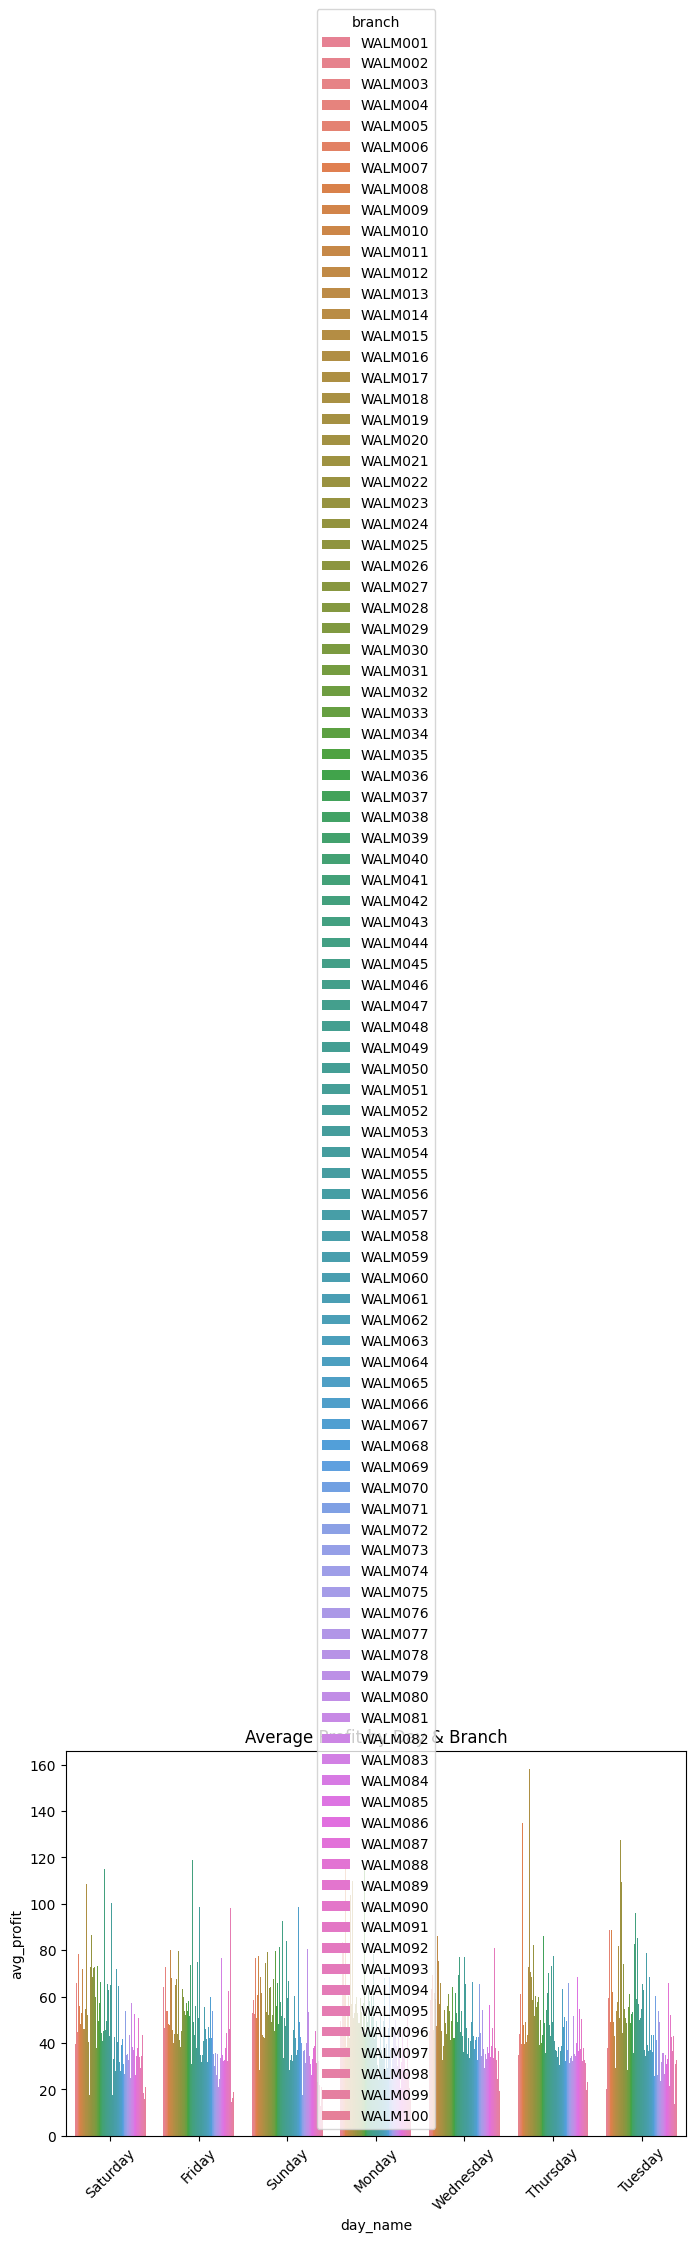

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

query2 = """
SELECT branch, DAYNAME(date) AS day_name, AVG(total_profit) AS avg_profit
FROM walmart
GROUP BY branch, day_name
ORDER BY branch, avg_profit DESC;
"""
df2 = pd.read_sql(query2, engine_mysql)
plt.figure(figsize=(8,5))
sns.barplot(data=df2, x='day_name', y='avg_profit', hue='branch')
plt.title("Average Profit by Day & Branch")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


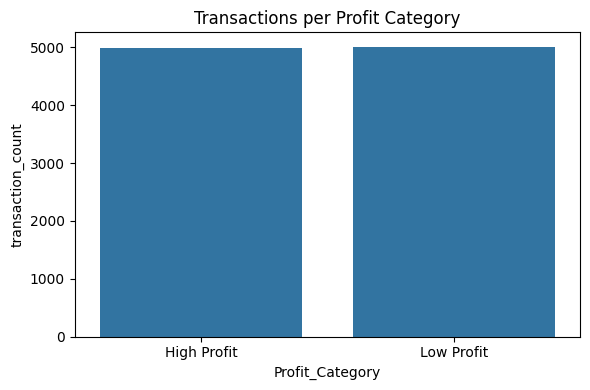

In [ ]:
# 5. Profit Category Distribution
query5 = """
SELECT Profit_Category, COUNT(*) AS transaction_count, SUM(Total_profit) AS total_profit
FROM walmart
GROUP BY Profit_Category
ORDER BY Total_profit DESC;
"""
df5 = pd.read_sql(query5, engine_mysql)
plt.figure(figsize=(6,4))
sns.barplot(data=df5, x='Profit_Category', y='transaction_count')
plt.title("Transactions per Profit Category")
plt.tight_layout()
plt.show()

C:\Users\Dilee\AppData\Local\Temp\ipykernel_20628\285243410.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payment_df, x="payment_method", y="no_of_payments", palette="Blues_d")


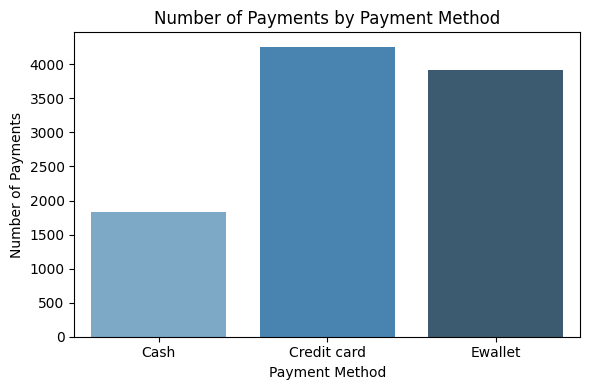

C:\Users\Dilee\AppData\Local\Temp\ipykernel_20628\285243410.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payment_df, x="payment_method", y="no_of_items_sold", palette="Greens_d")


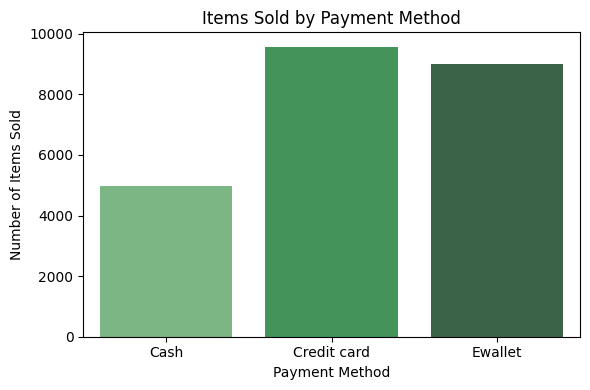

In [ ]:

# Number of payments & items sold by payment method
payment_df = df.groupby("payment_method").agg(
    no_of_payments=("invoice_id", "count"),
    no_of_items_sold=("quantity", "sum")
).reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=payment_df, x="payment_method", y="no_of_payments", palette="Blues_d")
plt.title("Number of Payments by Payment Method")
plt.ylabel("Number of Payments")
plt.xlabel("Payment Method")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=payment_df, x="payment_method", y="no_of_items_sold", palette="Greens_d")
plt.title("Items Sold by Payment Method")
plt.ylabel("Number of Items Sold")
plt.xlabel("Payment Method")
plt.tight_layout()
plt.show()


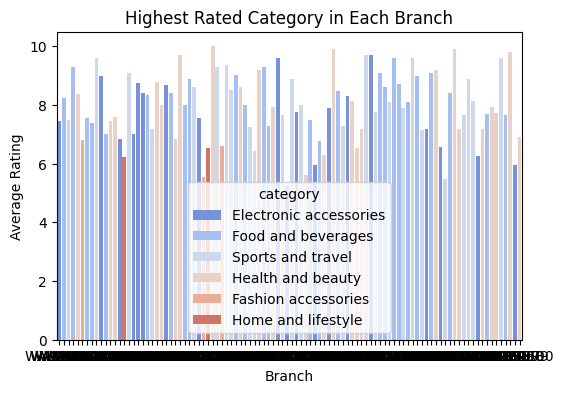

In [ ]:
# 2️ Highest rated category in every branch
highest_rated = (
    df.groupby(["Branch", "category"])["rating"].mean().reset_index()
)
highest_rated['rank'] = highest_rated.groupby("Branch")["rating"].rank(method="first", ascending=False)
highest_rated = highest_rated[highest_rated['rank'] == 1]

plt.figure(figsize=(6,4))
sns.barplot(data=highest_rated, x="Branch", y="rating", hue="category", palette="coolwarm")
plt.title("Highest Rated Category in Each Branch")
plt.ylabel("Average Rating")
plt.xlabel("Branch")
#plt.tight_layout()
plt.show()


C:\Users\Dilee\AppData\Local\Temp\ipykernel_20628\1980755014.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"])


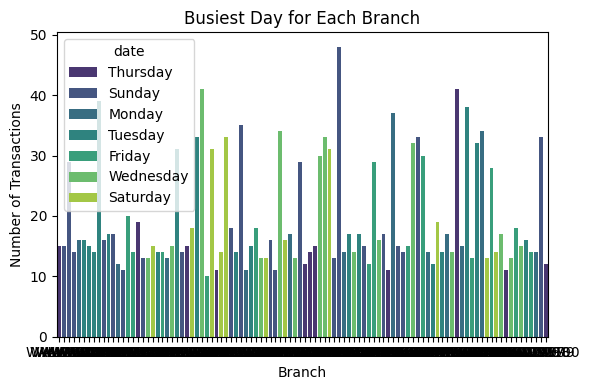

In [ ]:
# 3️ Busiest day per branch
# Ensure 'date' column is datetime
df["date"] = pd.to_datetime(df["date"])

busiest_day = (
    df.groupby(["Branch", df["date"].dt.day_name()])
    .size().reset_index(name="no_of_transactions")
)
busiest_day['rank'] = busiest_day.groupby("Branch")["no_of_transactions"].rank(method="first", ascending=False)
busiest_day = busiest_day[busiest_day['rank'] == 1]

plt.figure(figsize=(6,4))
sns.barplot(data=busiest_day, x="Branch", y="no_of_transactions", hue="date", palette="viridis")
plt.title("Busiest Day for Each Branch")
plt.ylabel("Number of Transactions")
plt.xlabel("Branch")
plt.tight_layout()
plt.show()

C:\Users\Dilee\AppData\Local\Temp\ipykernel_20628\1947684001.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=profit_per_branch, x="Branch", y="Total_profit", palette="magma")


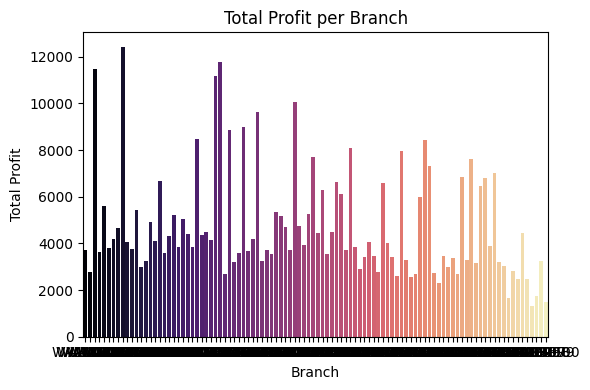

In [ ]:
# 4 Total profit per branch
profit_per_branch = df.groupby("Branch")["Total_profit"].sum().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=profit_per_branch, x="Branch", y="Total_profit", palette="magma")
plt.title("Total Profit per Branch")
plt.ylabel("Total Profit")
plt.xlabel("Branch")
plt.tight_layout()
plt.show()